In [1]:
import os
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.core.structure_tree import StructureTree
import numpy as np
import nrrd
import ipdb
import matplotlib.pyplot as plt
from scipy.io import savemat
from scipy.io import loadmat
from mcmodels.core.cortical_map import CorticalMap
import pandas as pd

In [2]:
def map_to_grid(image_vec, voxel_coords, view_lut):
    ''' 
    Returns 2D image with the size of view_lut and contents of coordinate mappings for vectorized solution.
    
    Parameters:
        image_vec (): image values
        voxel_coords (): image indices
        view_lut (): image shape
    '''
    #initialize the image to nans
    new_image = np.empty(view_lut.shape)
    new_image[:] = np.nan
    for i in range(image_vec.shape[0]):
        new_image[voxel_coords[i,0], voxel_coords[i,1]] = image_vec[i]
    return new_image

In [3]:
def histogram(X, Y, o_arr, x_quan, y_quan):
    '''
    Returns 3 histograms (projection, injection, omega) with x-axis: sum, y-axis: count. 
    
    Parameters"
        X: Injection matrice
        Y: Projection matrice
        o_arr: Omega output from matrice
        x_quan: quantile of values removed from X sums
        y_quan: quantile of values removed from Y sums
    '''
    # Initialize arrays, index i of x_cols represents col i of X
    y_cols = []
    x_cols = []
    o_cols = []
    
    # Calculate sums for columns of X, Y and Omega
    for i in range(Y.shape[1]):
        ycol = Y[:,i]
        xcol = X[:,i]
        ocol = o_arr[:,i]
        y_cols.append(np.sum(ycol))
        x_cols.append(np.sum(xcol))
        o_cols.append(np.sum(ocol))

    # Create a dataframe
    col_sums = pd.DataFrame({'y_cols': y_cols, 'x_cols': x_cols, 'o_cols' : o_cols})
    
    # Remove sums in the lowest percentiles and find indexes ...
    # ... of these sums in the dataframe
    y = col_sums['y_cols']
    x = col_sums['x_cols']

    y_removed = y.between(y.quantile(y_quan), y.quantile(1))
    y_indexes = col_sums[~y_removed].index

    x_removed = x.between(x.quantile(x_quan), x.quantile(1))
    x_indexes = col_sums[~x_removed].index
    
    # Indexes of sums are the same as the col index
    #print sums that were removed
    #print("sums removed from Y")
    #for i in y_indexes:
        #print(y_cols[i])

    #print("sums removed from X")
    #for j in x_indexes:
        #print(x_cols[j])

    # Uncomment to remove data from histogram
    #col_sums['y_cols'] = y[y.between(y.quantile(.04), y.quantile(1))]
    #col_sums['x_cols'] = x[x.between(x.quantile(.05), x.quantile(1))]
    
    #Display histogram
    col_sums.hist(bins=25)


In [23]:
def displayInjProj(vol, data_path, view_str,resolution_um,base):
    '''
    Returns projection and injection plots
    
    Parameters"
        vol: From get_2d_connectivity (contains list of experiments)
        view_str: 'top_view' or 'flatmap'
        resolution_um: resolution
        base: root folder where data is stored and saved
    '''
# Get injection and projection density, save images
    for eid in vol['experiment_ids']:
        data_dir = "experiment_%d/" % eid[0]
        data_dir = os.path.join(data_path, data_dir)
        # get and remap injection data
        in_fn = data_dir + "injection_density_" + view_str + "_%d.nrrd" \
          % int(resolution_um)
        in_d_s = nrrd.read(in_fn)[0]

        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20,5))
        ax[0].imshow(in_d_s)

        # get and remap projection data
        pr_fn = data_dir + "projection_density_" + view_str + "_%d.nrrd" \
          % int(resolution_um)
        pr_d_s = nrrd.read(pr_fn)[0]

        ax[1].imshow(pr_d_s)
        plt.savefig(base +"/"+view_str+"_d_s/" + '{:03}'.format(int(eid)))
        plt.clf()

In [24]:
def displayXYO(X,Y, o_arr, view_lut, voxel_coords_source, voxel_coords_target, num_exp, view_str, base):
    '''
    Returns X,Y,Omega plots
    
    Parameters"
        X,Y,Omega: Matrices for injection, projection and omega values
        view_lut: look up table
        voxel_source_coords: source coordinates (with X)
        voxel_target_coords: source coordinates (with Y, Omega)
        num_exp: number of experiments
        view_str: 'top_view' or 'flatmap'
        base: root folder where data is stored and saved
    '''
    #flatmap X, Y, Omega images after runnning create_2d_matrices.py
    for i in range(num_exp): 
        fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20,5))
        y_img = map_to_grid(Y[:,i], voxel_coords_target, view_lut)
        ax[0].imshow(y_img)

        x_img = map_to_grid(X[:,i], voxel_coords_source, view_lut)
        ax[1].imshow(x_img)

        o_img = map_to_grid(o_arr[:,i], voxel_coords_target, view_lut)
        ax[2].imshow(o_img)
        plt.savefig(base +"/"+view_str+"_xyo/" + '{:03}'.format(i))
        plt.clf()

In [25]:
# Get flatmap experiment data given 'flatmap' or 'top_view'
def getData(view_str, base):
    #Location of volumes.mat
    vol = loadmat(base + '/allen_get_connectivity_output/' + view_str+'_volumes.mat')
    # Flatmap matrices data
    matrices = loadmat(base + '/create_matrice_output/'+view_str+'/matrices.mat')
    
    
    return matrices, vol

In [30]:
# Call get data and retrieve voxel_coords, view_lut, X, Y, Omega
resolution_um = 100
view_type = 'top_view'
basefolder = '../original_0.8'
matrices, vol = getData(view_type, basefolder)


# Get path to experiments
data_path = basefolder + "/allen_sdk_experiments/"
if (view_type == 'top_view'):
    data_path = basefolder + "/allen_sdk_experiments_topview/"

# Retrieve matrices and voxel coords
voxel_coords_source = matrices['voxel_coords_source']
voxel_coords_target = matrices['voxel_coords_target']
view_lut = matrices['view_lut']
X = matrices['X']
Y = matrices['Y']
omega = matrices['Omega']

o_arr = omega.toarray()

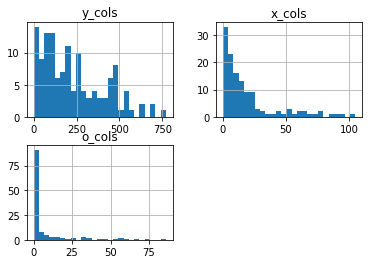

In [31]:
# Make histogram
hist = histogram(X, Y, o_arr, 0.05, 0.04)
plt.savefig(basefolder+ "/hist/"+view_type+"_hist")

In [32]:
# Save projection and injection visuals
displayInjProj(vol, data_path, view_type ,resolution_um, basefolder)

# Save X, Y, Omega visuals for each experiment
displayXYO(X,Y, o_arr, view_lut, voxel_coords_source, voxel_coords_target, 129, view_type, basefolder)

/tmp/ipykernel_5080/2779901353.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20,5))


<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>